In [1]:
# Code cell 1
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label


from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Code Cell 2
def readTrainingData(small=False):
    if small == True:
        cars = glob.glob('./small_training_data/vehicles/*/*.jpeg')
        notcars = glob.glob('./small_training_data/non-vehicles/*/*.jpeg')
    else:
        cars = glob.glob('./training_data/vehicles/*/*.png')
        notcars = glob.glob('./training_data/non-vehicles/*/*.png')
    return cars,notcars



def convert_color(img, conv='YCrCb'):
    if conv == "RGB":
        return np.copy(img)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [20]:
# Code Cell 3


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #print (file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image,color_space)
      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Data Visualization

In [4]:
# Code Cell 4


from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
    axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255)), ax=None):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    if ax == None:
        print ("New fig created")
        fig = plt.figure(figsize=(8, 8))
        ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    ax.set_title(''.join(axis_labels))
    return ax  # return Axes3D object for further manipulation



Your function returned a count of 8790  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


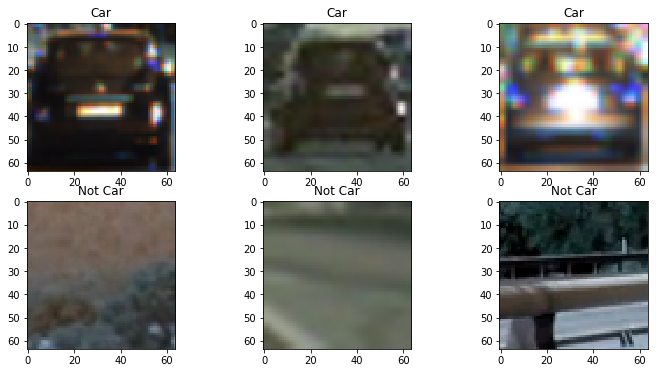

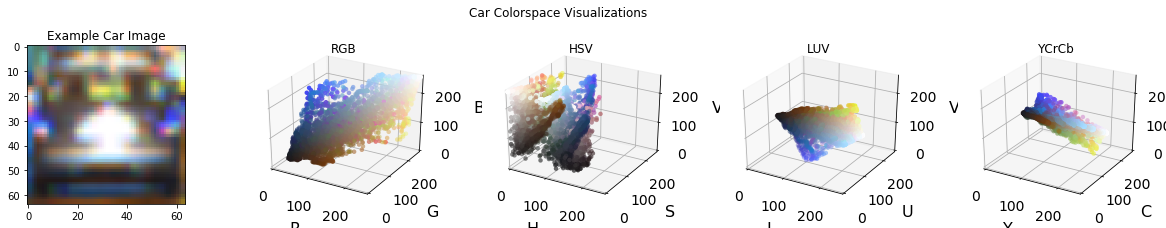

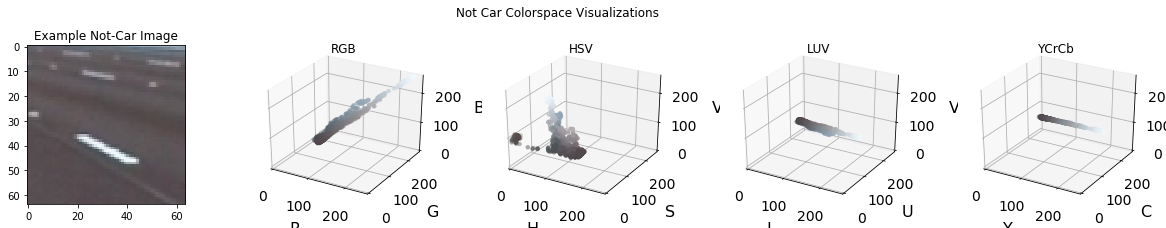

In [19]:
# Code Cell 5

cars, notcars = readTrainingData(small=False)


# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len (car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Show some random cars and not cars
f, ax = plt.subplots(2, 3, figsize=(12, 6))
for i in range(3):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    car_image = cv2.imread(cars[car_ind])
    notcar_image = cv2.imread(notcars[car_ind])
    ax[0][i].imshow(car_image)
    ax[0][i].set_title("Car")
    ax[1][i].imshow(notcar_image)
    ax[1][i].set_title("Not Car")

#Pick random images for 3D exploration of color spaces
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[car_ind])

#car_image = mpimg.imread(cars[car_ind])
#notcar_image = mpimg.imread(notcars[notcar_ind])

f, ax = plt.subplots(1, 5, figsize=(17, 3), subplot_kw={'projection':'3d'})
f.suptitle("Car Colorspace Visualizations")
f.subplots_adjust(left=0.05, wspace=0.1, top=0.9)

f.tight_layout()
ax = ax.ravel()
ax[0].remove()
ax[0]=f.add_subplot(151)
ax[0].imshow(car_image)
ax[0].set_title('Example Car Image')

# Select a small fraction of pixels to plot by subsampling it
scale = max(car_image.shape[0], car_image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(car_image, (np.int(car_image.shape[1] / scale), np.int(car_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)


# Convert subsampled image to desired color space(s)
img_small_RGB = img_small  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = convert_color(img_small, "HSV")
img_small_LUV = convert_color(img_small, "LUV")
img_small_YCrCb = convert_color(img_small, "YCrCb")

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting


plot3d(img_small_RGB, img_small_rgb, ax=ax[1])
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"), ax=ax[2])
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"), ax=ax[3])
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"), ax=ax[4])

f.subplots_adjust(left=0.05, wspace=0.2, top=0.8)
plt.show()

f, ax = plt.subplots(1, 5, figsize=(17, 3), subplot_kw={'projection':'3d'})
f.suptitle("Not Car Colorspace Visualizations")
f.subplots_adjust(left=0.05, wspace=0.1, top=0.9)

f.tight_layout()
ax = ax.ravel()
ax[0].remove()
ax[0]=f.add_subplot(151)
ax[0].imshow(notcar_image)
ax[0].set_title('Example Not-Car Image')

# Select a small fraction of pixels to plot by subsampling it
scale = max(notcar_image.shape[0], notcar_image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(notcar_image, (np.int(notcar_image.shape[1] / scale), np.int(notcar_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)


# Convert subsampled image to desired color space(s)
img_small_RGB = img_small  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = convert_color(img_small, "HSV")
img_small_LUV = convert_color(img_small, "LUV")
img_small_YCrCb = convert_color(img_small, "YCrCb")

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting


plot3d(img_small_RGB, img_small_rgb, ax=ax[1])
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"), ax=ax[2])
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"), ax=ax[3])
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"), ax=ax[4])

f.subplots_adjust(left=0.05, wspace=0.2, top=0.8)


plt.show()

## Hog Visualization

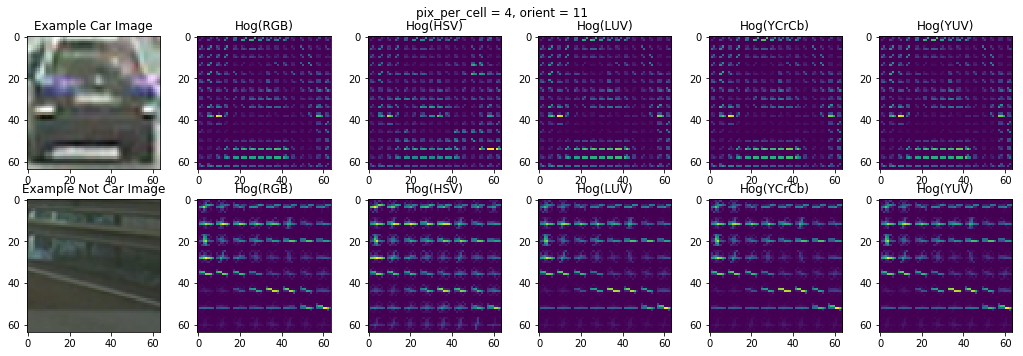

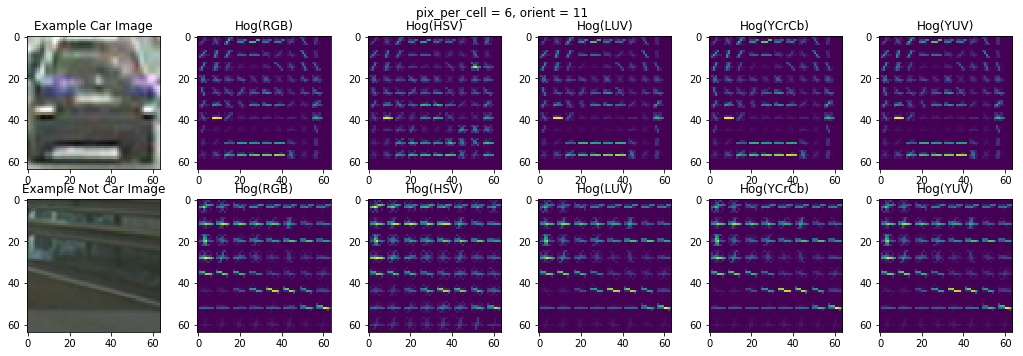

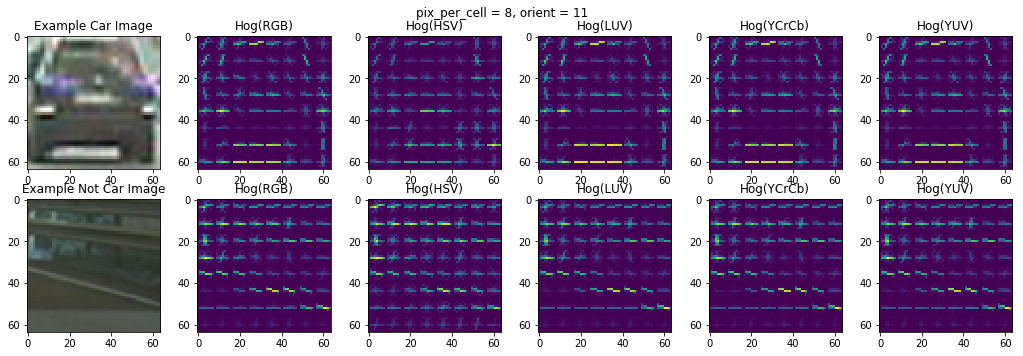

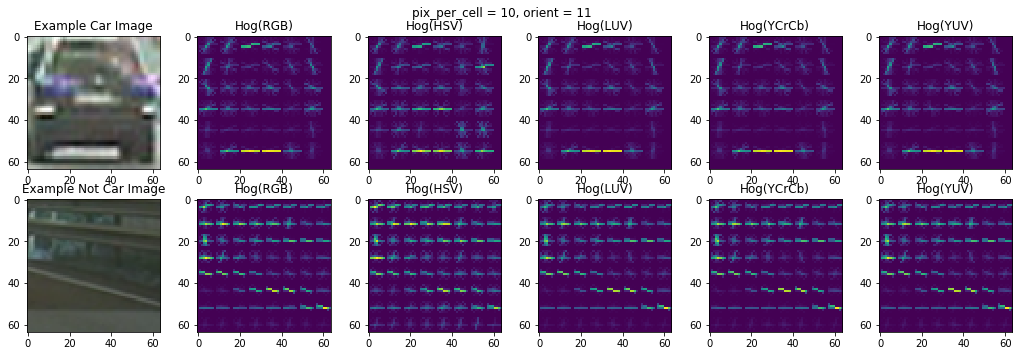

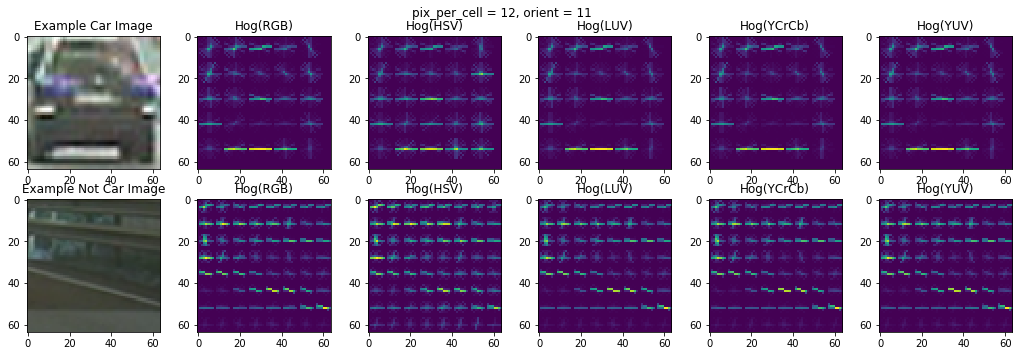

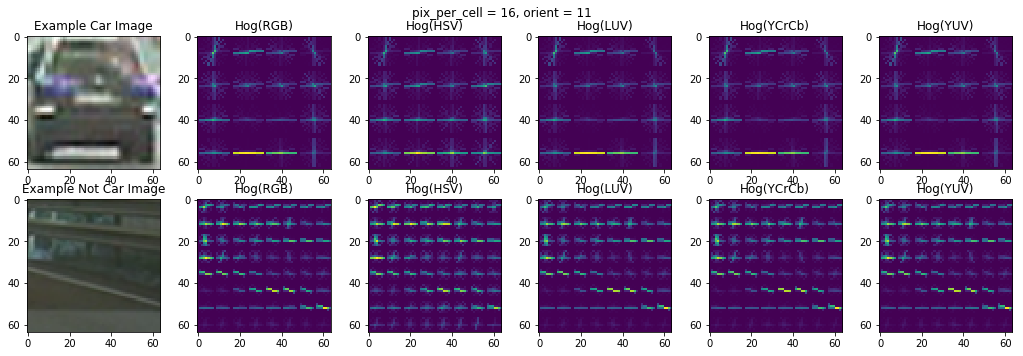

In [6]:
# Code Cell 7
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[car_ind])

#car_image = mpimg.imread(cars[car_ind])
#notcar_image = mpimg.imread(notcars[notcar_ind])

#Play with orient to see how it affects Hog
orient = 11
for pix_per_cell in [4,6,8,10,12,16]:
    f, ax = plt.subplots(2, 6, figsize=(15, 5))

    f.tight_layout()

    ax[0][0].imshow(car_image)
    ax[0][0].set_title('Example Car Image')
    ax[1][0].imshow(notcar_image)
    ax[1][0].set_title('Example Not Car Image')


    img_no = 1
    for color in ["RGB", "HSV", "LUV", "YCrCb", "YUV"]:
        car_color = convert_color(car_image,color)
        notcar_color = convert_color(notcar_image, color)

        features, hog_image = get_hog_features(car_color, orient= orient, 
                            pix_per_cell= pix_per_cell, cell_per_block= 2, 
                            vis=True, feature_vec=False)

        ax[0][img_no].imshow(hog_image)
        ax[0][img_no].set_title("Hog(%s)" % (color))

        features, hog_image = get_hog_features(notcar_color, orient= orient, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)

        ax[1][img_no].imshow(hog_image)
        ax[1][img_no].set_title("Hog(%s)" % (color))

        img_no += 1


    f.suptitle("pix_per_cell = %d, orient = %d" % (pix_per_cell,orient))
    f.subplots_adjust(left=0.05, wspace=0.1, top=0.9)
    plt.show()




In [21]:
# Code Cell 7a

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img,color_space)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [22]:
# Code Cell 8

# Divide up into cars and notcars
#images = glob.glob('*.jpeg')
cars, notcars = readTrainingData(small=False)

print (len(cars),len(notcars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 2000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

"""
# Other combinations tried
# 
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# NEW 2

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
"""

#
print ("Extracting car features.....")
y_start_stop = [450, None] # Min and max in y to search in slide_window()
print ("Loading images and extracting features....")
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ("Extracting not car features.....")

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ("Training....")
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



8790 8968
Extracting car features.....
Loading images and extracting features....
Extracting not car features.....
Training....
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7332
4.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


In [23]:
# Code Cell 9


print ("svc", svc)
print ("X_scaler", X_scaler)
print ("orient", orient)
print ("pix_per_cell", pix_per_cell)
print ("cell_per_block", cell_per_block)
print ("spatial_size", spatial_size)
print ("hist_bins", hist_bins)
print ("X_Scaler vars", vars(X_scaler))

# Save the training classifier and properties result
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
#dist_pickle["colorspace"] = colorspace
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)
orient 11
pix_per_cell 8
cell_per_block 2
spatial_size (16, 16)
hist_bins 32
X_Scaler vars {'scale_': array([0.21681096, 0.03317392, 0.04242023, ..., 0.06886418, 0.06784599,
       0.08124328]), 'with_mean': True, 'n_samples_seen_': 14206, 'with_std': True, 'copy': True, 'mean_': array([0.34243039, 0.49645199, 0.48873331, ..., 0.07485564, 0.07049272,
       0.07675377]), 'var_': array([0.04700699, 0.00110051, 0.00179948, ..., 0.00474228, 0.00460308,
       0.00660047])}


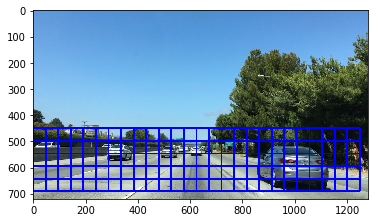

In [28]:
# Code Cell 10


image = mpimg.imread('test_images/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)



svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)
orient 11
pix_per_cell 8
cell_per_block 2
spatial_size (16, 16)
hist_bins 32
X_Scaler vars {'with_mean': True, 'var_': array([0.04700699, 0.00110051, 0.00179948, ..., 0.00474228, 0.00460308,
       0.00660047]), 'n_samples_seen_': 14206, 'with_std': True, 'copy': True, 'mean_': array([0.34243039, 0.49645199, 0.48873331, ..., 0.07485564, 0.07049272,
       0.07675377]), 'scale_': array([0.21681096, 0.03317392, 0.04242023, ..., 0.06886418, 0.06784599,
       0.08124328])}


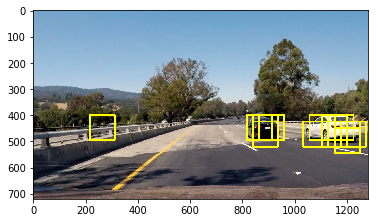

In [29]:
# Code Cell 11



import numpy as np
import cv2
from skimage.feature import hog


# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print ("svc", svc)
print ("X_scaler", X_scaler)
print ("orient", orient)
print ("pix_per_cell", pix_per_cell)
print ("cell_per_block", cell_per_block)
print ("spatial_size", spatial_size)
print ("hist_bins", hist_bins)
print ("X_Scaler vars", vars(X_scaler))

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
    #ctrans_tosearch = convert_color(img_tosearch, conv='YUV')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            #print ("spatial_features",spatial_features.shape)
            #print ("hist_features",hist_features.shape)
            #print ("hog_features",hog_features.shape)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print (test_prediction)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,255,0),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            #else:
            #    print ("Car not found @",xleft*scale,ytop*scale,window*scale)
                
    return draw_img, boxes
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

bx:  [((832, 416), (896, 480)), ((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((880, 416), (944, 480)), ((880, 432), (944, 496)), ((1072, 400), (1136, 464))]
bx:  [((216, 400), (312, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((1032, 424), (1128, 520)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1128, 400), (1224, 496)), ((1152, 424), (1248, 520)), ((1152, 448), (1248, 544)), ((1176, 424), (1272, 520))]
bx:  [((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]
bx:  [((48, 400), (240, 592))]
bx:  []
[((832, 416), (896, 480)), ((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((880, 416), (944, 480)), ((880, 432), (944, 496)), ((1072, 400), (1136, 464)), ((216, 400), (312, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840,

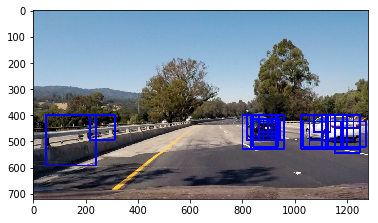

In [31]:
# Code Cell 12


ystart = 400
ystop = 656
boxes = []
for scale in [1.0,1.5,2.0,3.0,3.5]:
    out_img, bx = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    print ("bx: ",bx)
    boxes = boxes + bx
    
#boxes = [item for sublist in boxes for item in sublist] 

print (boxes)

combined_img = draw_boxes(img, boxes, color=(0, 0, 255), thick=6)                    

plt.imshow(combined_img)

(720, 1280, 3)
(720, 1280)


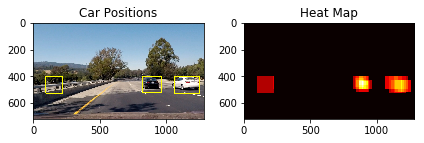

In [15]:
# Code Cell 13



box_list = boxes

image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.uint8)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print ("Box: ",box)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,0), 6)
        boxes.append(bbox)
    # Return the image
    return img,boxes

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heat)
draw_img,cars = draw_labeled_bboxes(np.copy(image), labels)

print (draw_img.shape)
print (heatmap.shape)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [16]:
# Code Cell 14


def simpleImageProcess(image):
    ystart = 400
    ystop = 656
    boxes = []
    #for scale in [1.0,1.2,1.4,1.6,2.0]:
    for scale in [1.0,1.5,2.5,3.5]:
        out_img, bx = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        print ("bx: ",bx)
        boxes = boxes + bx
        
    heat = np.zeros_like(image[:,:,0]).astype(np.uint8)


    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img,cars = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

In [17]:
# Code Cell 15


class FrameHistory():
    
    def __init__(self):
        self.frame_heats = []
        self.avg_heat = []
        self.threshold = 2
        self.debug = False
        return
    
    def saveHeatmap(self,heat):
        self.frame_heats.append(heat)
        if len(self.frame_heats) > 10:
            self.frame_heats.pop(0)
        self.avg_heat = np.sum(self.frame_heats, axis = 0)
        self.threshold = len(self.frame_heats)//2 + 2
        #self.threshold = 2
        return self.avg_heat

def drawDebug(image, message):
    font = cv2.FONT_HERSHEY_PLAIN
    cv2.putText(image,message,(30,50),font, 2, (255,255,0), 2, cv2.LINE_AA)

    return image

def process_image (image):
    ystart = 400
    ystop = 656
    boxes = []
    #for scale in [0.75,1.0,1.5,2.0,3.0,3.5]:
    #for scale in [0.75,1.5,2.5,3.0,3.5]:
    for scale in [1.0,1.5,2.0,3.0]:
    #for scale in [0.75,1.5,3.0]:
    #for scale in [0.75,1.0,1.5,2.5,3.0,3.5]:
        out_img, bx = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes = boxes + bx


    heat = np.zeros_like(image[:,:,0]).astype(np.uint8)
    zeros = np.zeros_like(image[:,:,0]).astype(np.uint8)
    
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    if state.debug:
        frame_heatmap = np.clip(heat*16, 0, 255).astype(np.uint8)
    if len(boxes) > 0:
        # Apply threshold before saving and getting the mean
        heat = apply_threshold(heat,1)
        heat = state.saveHeatmap(heat)

    #heat = state.saveHeatmap(heat)
    # Apply threshold to help remove false positives
    #print ("Threshold: ",state.threshold)
    heat = apply_threshold(heat,state.threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat*16, 0, 255).astype(np.uint8)

    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img,cars = draw_labeled_bboxes(np.copy(image), labels)

    if state.debug:
        # If debug, show the current and average heatmaps
        size = (640, 360)
        res_heatmap = cv2.resize(np.dstack([heatmap, zeros, zeros]), size)
        text = "Threshold: %.2f Len: %d" % (state.threshold,len(state.frame_heats))
        res_heatmap = drawDebug(res_heatmap,text)
        res_frame_heatmap = cv2.resize(np.dstack([zeros, frame_heatmap, zeros]), size)
        panel = np.hstack((res_frame_heatmap, res_heatmap))
        draw_img = np.vstack((panel,draw_img))


    return draw_img

    


./test_images/test6.jpg


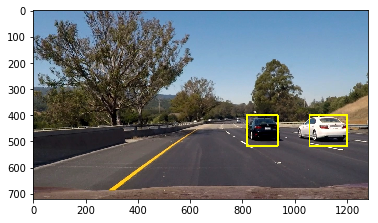

./test_images/test5.jpg


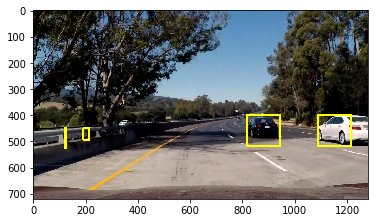

./test_images/test4.jpg


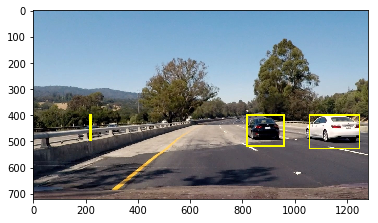

./test_images/test1.jpg


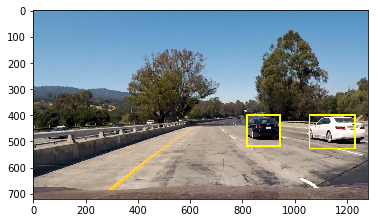

./test_images/test3.jpg


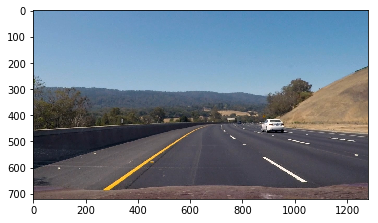

./test_images/test2.jpg


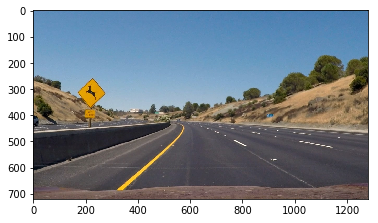

In [19]:
# Code Cell 16


test_images = glob.glob('./test_images/test*.jpg')
for fname in test_images:
    state = FrameHistory()
    print (fname)
    image = mpimg.imread(fname)
    plt.imshow(process_image(image))
    #plt.imshow(simpleImageProcess(image))
    plt.show()

In [20]:
#Code Cell 17
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

state = FrameHistory()
state.debug = False

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(5,25)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(19.0)
#clip1 = clip1.set_duration(7.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [1:01:36<00:02,  2.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 3h 32min 58s, sys: 9min 9s, total: 3h 42min 7s
Wall time: 1h 1min 37s
